# Лабораторная работа 2

### Выполнил: Хамитов А. гр. 9308



---



# Предварительный анализ данных

## О данных

Отдел надзора в каждой стране проводит общепринятую оценку качества питания для различных заведений общественного питания в черте города. Это ужасно хорошо заархивированная процедура.

Отдел проверки хотел бы предсказать, на чем им следует сосредоточить больше всего внимания с точки зрения их следующего плана проверки, чтобы они могли максимально оптимизировать свое время.

Может ли предыдущая оценка или любая информация, которую они собрали, предсказать, какая оценка будет успешной или нет?

Ваша цель состоит в том, чтобы предсказать, пройдет ли оценка или не пройдёт оценку, основываясь на ряде компонентов.

## Импорт необходимых библиотек

In [1]:
import warnings
warnings.filterwarnings('always')  # "error", "ignore", "always", "default", "module" or "once"

import pandas as pd
import numpy as np
import seaborn as sns                       #visualisation
import matplotlib.pyplot as plt             #visualisation
from sklearn import preprocessing
import random
%matplotlib inline     



---



## Загрузка данных в датафрейм

Так как наш набор данных в формате csv, прочитаем его следующей функцией в pandas (опционально можно подключить гугл диск, чтобы брать датасеты из него)

In [2]:
#from google.colab import drive
#drive.mount('/content/drive')

In [3]:
df = pd.read_csv("data.csv")
# To display the top 5 rows 
df.head()               

,ID,Date,LicenseNo,Assessment_ID,Assessment_Name,Restaurent Type,Street ID,City ID,State ID,LocationID,Reason,SectionViolations,Risk_level,Geographical_Location,Assessment_Results
0,0,07/08/2017,35576,27170,25928,RESTAURANT,14291,id-11235901,id_1890134,81874.0,COMPLAINT,3.0,High,locid3070,1
1,1,28/06/2016,33490,9159,8683,BAKERY,15266,id-11235901,id_1890134,81876.0,CANVASS,18.0,High,locid16348,1
2,2,06/07/2014,1716,12151,11559,RESTAURANT,10113,id-11235901,id_1890134,81886.0,CANVASS,32.0,High,locid13425,4
3,3,03/06/2015,11101,12030,11446,RESTAURANT,274,id-11235901,id_1890134,81873.0,COMPLAINT,18.0,High,locid656,1
4,4,26/02/2017,28642,21406,20451,RESTAURANT,7338,id-11235901,id_1890134,81902.0,CANVASS,34.0,High,locid12104,4


## Удаление классов из данных

In [4]:
df.Assessment_Results.value_counts()

4    75443
1    23452
5    10631
6     4998
3     2247
2      700
0       20
Name: Assessment_Results, dtype: int64

Значения каждого из классов:<br>
0 : ОБЪЕКТ ИЗМЕНЕН<br>
1 : НЕ ПРОШЕЛ<br>
2 : ТРЕБУЕТСЯ ДОПОЛНИТЕЛЬНАЯ ПРОВЕРКА<br>
3 : ПРОВЕРКА ОТМЕНЕНА<br>
4 : ПРОШЕЛ<br>
5 : ПРОЙДЕНО С НЕКОТОРЫМИ УСЛОВИЯМИ<br>
6 : ВЫКЛЮЧЕНИЕ

Можем обратить внимание на то, что категории 0, 2, 3 слишком редко встречаемые. Учитывая цель, которую мы хотим достичь - эти классы можно отбросить. 

In [5]:
df = df.drop(df[df.Assessment_Results == 4].sample(n=50000).index)
df = df.loc[df['Assessment_Results'].isin([1, 4, 5])]
df.Assessment_Results.value_counts()
df.head

<bound method NDFrame.head of             ID        Date  LicenseNo  Assessment_ID  Assessment_Name  \
0            0  07/08/2017      35576          27170            25928   
1            1  28/06/2016      33490           9159             8683   
3            3  03/06/2015      11101          12030            11446   
5            5  09/05/2017      28148          21824            20855   
7            7  03/05/2017      33924          18109            17307   
...        ...         ...        ...            ...              ...   
117475  117475  10/03/2009       8630          22897            21868   
117482  117482  22/03/2009      36033          26595            25365   
117483  117483  26/01/2010      10528          10703            10154   
117488  117488  04/03/2015      19374          22408            21426   
117490  117490  20/04/2009      12316          18813            17982   

       Restaurent Type  Street ID      City ID    State ID  LocationID  \
0           RESTAUR

In [6]:
df.tail(5)                        # To display the botton 5 rows

,ID,Date,LicenseNo,Assessment_ID,Assessment_Name,Restaurent Type,Street ID,City ID,State ID,LocationID,Reason,SectionViolations,Risk_level,Geographical_Location,Assessment_Results
117475,117475,10/03/2009,8630,22897,21868,RESTAURANT,4529,id-11235901,id_1890134,81894.0,COMPLAINT,34.0,High,locid2313,4
117482,117482,22/03/2009,36033,26595,25365,NaN,17727,id-11235901,id_1890134,81867.0,SHORT FORM COMPLAINT,NaN,High,locid9114,4
117483,117483,26/01/2010,10528,10703,10154,RESTAURANT,4240,id-11235901,id_1890134,81881.0,CANVASS,21.0,High,locid2876,5
117488,117488,04/03/2015,19374,22408,21426,SCHOOL,11481,id-11235901,id_1890134,81897.0,CANVASS,26.0,High,locid1341,1
117490,117490,20/04/2009,12316,18813,17982,GROCERY STORE,16332,id-11235901,id_1890134,81881.0,LICENSE RE-INSPECTION,38.0,Medium,locid2055,1




---



## Проверка типов данных

Здесь мы проверяем типы данных, потому что иногда цена автомобиля хранится в виде строки, поэтому следует преобразовать эту строку в целочисленные данные, только тогда возможно отобразить данные на графике. В данном случае данные уже представлены в целочисленном формате, поэтому беспокоиться не о чем.

In [7]:
df.dtypes

ID                         int64
Date                      object
LicenseNo                  int64
Assessment_ID              int64
Assessment_Name            int64
Restaurent Type           object
Street ID                  int64
City ID                   object
State ID                  object
LocationID               float64
Reason                    object
SectionViolations        float64
Risk_level                object
Geographical_Location     object
Assessment_Results         int64
dtype: object



---



## Удаление нерелевантных колонок

Этот шаг, в каждом анализе данных, потому что иногда в наборе данных представлены неиспользуемые столбцы, которые следует отбросить. 

In [8]:
print(df['City ID'].value_counts())
df['State ID'].value_counts()

id-11235901    59440
id-11275913       86
Name: City ID, dtype: int64


id_1890134    59510
id_1890135       16
Name: State ID, dtype: int64

In [9]:
df = df.drop(['ID', 'Assessment_ID', 'LicenseNo', 'City ID', 'State ID', 'Date'], axis=1)
df.head(5)

,Assessment_Name,Restaurent Type,Street ID,LocationID,Reason,SectionViolations,Risk_level,Geographical_Location,Assessment_Results
0,25928,RESTAURANT,14291,81874.0,COMPLAINT,3.0,High,locid3070,1
1,8683,BAKERY,15266,81876.0,CANVASS,18.0,High,locid16348,1
3,11446,RESTAURANT,274,81873.0,COMPLAINT,18.0,High,locid656,1
5,20855,RESTAURANT,17307,81897.0,CANVASS,33.0,High,locid1162,4
7,17307,SCHOOL,5609,81857.0,CANVASS,3.0,Low,locid6560,1




---



## Переименование столбцов

В данном случае большинство названий столбцов нечитаемы, поэтому переименуем их.

In [10]:
df = df.rename(columns={"Restaurent Type": "RestaurentType"})
df.head(5)

,Assessment_Name,RestaurentType,Street ID,LocationID,Reason,SectionViolations,Risk_level,Geographical_Location,Assessment_Results
0,25928,RESTAURANT,14291,81874.0,COMPLAINT,3.0,High,locid3070,1
1,8683,BAKERY,15266,81876.0,CANVASS,18.0,High,locid16348,1
3,11446,RESTAURANT,274,81873.0,COMPLAINT,18.0,High,locid656,1
5,20855,RESTAURANT,17307,81897.0,CANVASS,33.0,High,locid1162,4
7,17307,SCHOOL,5609,81857.0,CANVASS,3.0,Low,locid6560,1




---



## Удаление дубликатов

Большой набор данных (более 10 000 строк), часто может содержать в себе дубликаты. Например, до удаления в данном наборе было 11914 строк данных, а после удаления дубликатов 10925, таким образом набор данных содержал 989 строк дубликатов.

In [11]:
df.shape

(59526, 9)

In [12]:
duplicate_rows_df = df[df.duplicated()]
print("number of duplicate rows: ", duplicate_rows_df.shape)

number of duplicate rows:  (3284, 9)


In [13]:
df.count()      # Used to count the number of rows

Assessment_Name          59526
RestaurentType           59236
Street ID                59526
LocationID               59516
Reason                   59526
SectionViolations        51825
Risk_level               59526
Geographical_Location    59526
Assessment_Results       59526
dtype: int64

В датафрейме представлено 11914 строк, удалим 989 строк, содержащих дубликаты.

In [14]:
df = df.drop_duplicates()
df.head(5)

,Assessment_Name,RestaurentType,Street ID,LocationID,Reason,SectionViolations,Risk_level,Geographical_Location,Assessment_Results
0,25928,RESTAURANT,14291,81874.0,COMPLAINT,3.0,High,locid3070,1
1,8683,BAKERY,15266,81876.0,CANVASS,18.0,High,locid16348,1
3,11446,RESTAURANT,274,81873.0,COMPLAINT,18.0,High,locid656,1
5,20855,RESTAURANT,17307,81897.0,CANVASS,33.0,High,locid1162,4
7,17307,SCHOOL,5609,81857.0,CANVASS,3.0,Low,locid6560,1


In [15]:
df.count()

Assessment_Name          56242
RestaurentType           55957
Street ID                56242
LocationID               56232
Reason                   56242
SectionViolations        48980
Risk_level               56242
Geographical_Location    56242
Assessment_Results       56242
dtype: int64

## Удаление пропусков

Этот шаг в основном похож на предыдущий, но здесь все отсутствующие значения определяются и отбрасываются. Также применяются тактики замены отсутствующих значений средним значением или средним значением этого столбца. В данном случае пропущено 99 значений - достаточная низкая доля всего набора данных из 10000 значений, поэтому удаление строк с пропущенными значениями не критично. 

In [16]:
print(df.isnull().sum())

Assessment_Name             0
RestaurentType            285
Street ID                   0
LocationID                 10
Reason                      0
SectionViolations        7262
Risk_level                  0
Geographical_Location       0
Assessment_Results          0
dtype: int64


In [17]:
df = df.dropna()    # Dropping the missing values.
df.count()

Assessment_Name          48932
RestaurentType           48932
Street ID                48932
LocationID               48932
Reason                   48932
SectionViolations        48932
Risk_level               48932
Geographical_Location    48932
Assessment_Results       48932
dtype: int64

Удалили все строки с пропущенными значениями (Restaurent Type и SectionViolations).

In [18]:
print(df.isnull().sum())   # After dropping the values

Assessment_Name          0
RestaurentType           0
Street ID                0
LocationID               0
Reason                   0
SectionViolations        0
Risk_level               0
Geographical_Location    0
Assessment_Results       0
dtype: int64


## Замена категориальных переменных

In [19]:
df['Risk_level'].value_counts()

High      36416
Medium     9463
Low        3053
Name: Risk_level, dtype: int64

In [20]:
num_replace = {'Risk_level': {'High': 3, 'Medium': 2, 'Low': 1}, 'Reason': {}, 'RestaurentType': {}}

freq = df['Reason'].value_counts()
for index in freq.index:
    num_replace['Reason'][index] = freq[index]
    
freq = df['RestaurentType'].value_counts()
for index in freq.index:
    num_replace['RestaurentType'][index] = freq[index]

df = df.replace(num_replace)

df.head()

,Assessment_Name,RestaurentType,Street ID,LocationID,Reason,SectionViolations,Risk_level,Geographical_Location,Assessment_Results
0,25928,33469,14291,81874.0,6546,3.0,3,locid3070,1
1,8683,766,15266,81876.0,25833,18.0,3,locid16348,1
3,11446,33469,274,81873.0,6546,18.0,3,locid656,1
5,20855,33469,17307,81897.0,25833,33.0,3,locid1162,4
7,17307,3254,5609,81857.0,25833,3.0,1,locid6560,1


In [21]:
# df["City ID"] = df["City ID"].str.replace(r"[^\d\.]", "", regex=True)
# df["State ID"] = df["State ID"].str.replace(r"[^\d\.]", "", regex=True)
df["Geographical_Location"] = df["Geographical_Location"].str.replace(r"[^\d\.]", "", regex=True)
df.dtypes

Assessment_Name            int64
RestaurentType             int64
Street ID                  int64
LocationID               float64
Reason                     int64
SectionViolations        float64
Risk_level                 int64
Geographical_Location     object
Assessment_Results         int64
dtype: object



---



## Определение выбросов

Выброс - это точка или набор точек, которые отличаются от других точек. Характеризуются очень высокими или очень низкими. Часто бывает полезно обнаружить и удалить выбросы. Выбросы являются одной из основных причин, приводящих к созданию менее точной модели. Метод обнаружения и удаления выбросов, примененный здесь - IQR. Часто выбросы можно увидеть с помощью визуализации, используя т.н. "ящик с усами". Ниже показаны графики MSRP, Cylinders, Horsepower и EngineSize. На всех графиках можно увидеть, что некоторые точки выходят за пределы коробки - это не что иное, как выбросы. 

In [22]:
df.head()

,Assessment_Name,RestaurentType,Street ID,LocationID,Reason,SectionViolations,Risk_level,Geographical_Location,Assessment_Results
0,25928,33469,14291,81874.0,6546,3.0,3,3070,1
1,8683,766,15266,81876.0,25833,18.0,3,16348,1
3,11446,33469,274,81873.0,6546,18.0,3,656,1
5,20855,33469,17307,81897.0,25833,33.0,3,1162,4
7,17307,3254,5609,81857.0,25833,3.0,1,6560,1


19.0


<AxesSubplot: xlabel='SectionViolations'>

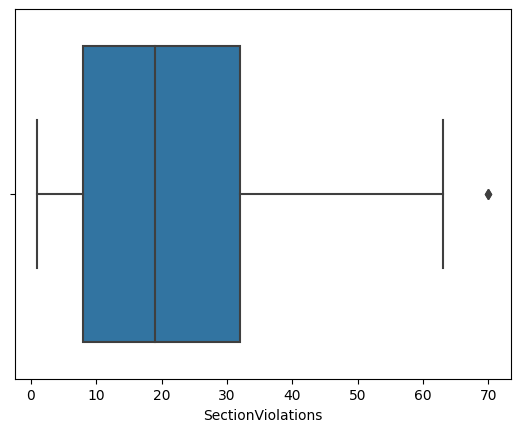

In [23]:
print(df.SectionViolations.median())
sns.boxplot(x=df['SectionViolations'])

In [24]:
columns_int = df.select_dtypes(include=["int64", "float64"])

In [25]:
for x in columns_int:
    q75,q25 = np.percentile(df.loc[:,x],[75,25])
    intr_qr = q75-q25

    max = q75+(1.5*intr_qr)
    min = q25-(1.5*intr_qr)

    df.loc[df[x] < min,x] = np.nan
    df.loc[df[x] > max,x] = np.nan

In [26]:
df.isnull().sum()

Assessment_Name            0
RestaurentType             0
Street ID                  0
LocationID               359
Reason                     0
SectionViolations          2
Risk_level                 0
Geographical_Location      0
Assessment_Results         0
dtype: int64

In [27]:
df = df.dropna()
df.isnull().sum()

Assessment_Name          0
RestaurentType           0
Street ID                0
LocationID               0
Reason                   0
SectionViolations        0
Risk_level               0
Geographical_Location    0
Assessment_Results       0
dtype: int64

Как видно из вышеприведенного, около 1600 строк были пропущены. Но не получится полностью удалить выбросы, потому что даже после использования вышеописанной техники, возможно, 1-2 выброса останутся не удаленными, тем не менее, выбросов было более 100. 



---



## Нормализация данных

In [28]:
# df.loc[:, df.columns != 'Assessment_Results']
df['Geographical_Location'] = df['Geographical_Location'].astype(float)
df.dtypes

Assessment_Name          float64
RestaurentType           float64
Street ID                float64
LocationID               float64
Reason                   float64
SectionViolations        float64
Risk_level               float64
Geographical_Location    float64
Assessment_Results       float64
dtype: object

In [29]:
cdf = df
cdf = (df-df.min ())/(df.max ()-df.min ())
scaled_df = cdf

## Тепловые карты

Тепловые карты - это тип графика, который необходим для поиска зависимых переменных. Один из лучших способов найти взаимосвязь между характеристиками: тепловые карты. На приведенной ниже тепловой карте видно. что ценовая характеристика в основном зависит от мощности и года выпуска

<AxesSubplot: >

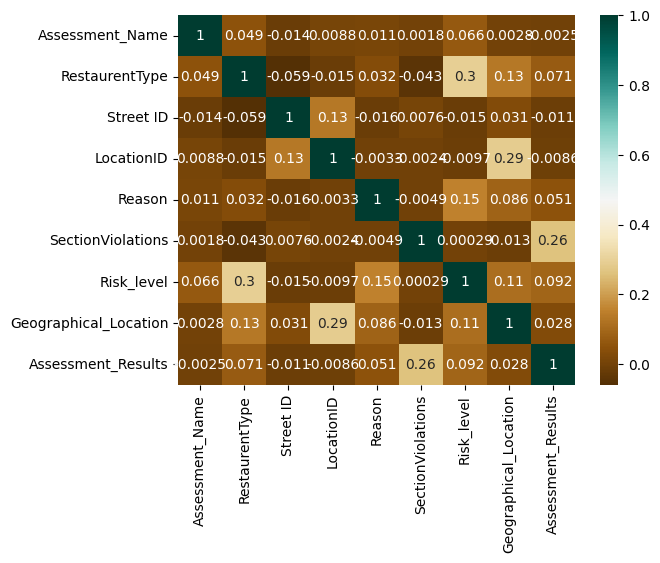

In [30]:
sns.heatmap(scaled_df.corr(),cmap="BrBG",annot=True)

## Построение моделей

## PCA

In [31]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

import matplotlib.pyplot as plt
import numpy as np

import seaborn as sns
import pandas as pd 
sns.set(style="white")
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
from sklearn import datasets, decomposition
from imblearn.over_sampling import SMOTE


In [32]:
data_final = scaled_df

X = data_final.loc[:, data_final.columns != 'Assessment_Results']
y = df.loc[:, df.columns == 'Assessment_Results']


In [33]:
sm=SMOTE()
X,y=sm.fit_resample(X,y)

In [34]:
y

,Assessment_Results
0,1.0
1,1.0
2,1.0
3,4.0
4,1.0
...,...
60367,5.0
60368,5.0
60369,5.0
60370,5.0


In [35]:
pd.DataFrame(X)

,Assessment_Name,RestaurentType,Street ID,LocationID,Reason,SectionViolations,Risk_level,Geographical_Location
0,0.996120,1.000000,0.798815,0.430769,0.252963,0.032258,1.0,0.182619
1,0.333564,0.022858,0.853318,0.461538,1.000000,0.274194,1.0,0.972459
2,0.439719,1.000000,0.015261,0.415385,0.252963,0.274194,1.0,0.039022
3,0.801214,1.000000,0.967410,0.784615,1.000000,0.516129,1.0,0.069121
4,0.664899,0.097197,0.313489,0.169231,1.000000,0.032258,0.0,0.390221
...,...,...,...,...,...,...,...,...
60367,0.913831,0.175273,0.370765,0.273779,0.253218,0.035925,1.0,0.848575
60368,0.741961,0.170290,0.286933,0.251945,0.252963,0.018153,0.5,0.082401
60369,0.335917,1.000000,0.355258,0.707692,1.000000,0.028630,1.0,0.685424
60370,0.737847,1.000000,0.886256,0.384615,0.253873,0.022662,1.0,0.986195


In [36]:
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

# Выделим из наших данных валидационную выборку
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

# Для примера возьмём неглубокое дерево решений
clf = DecisionTreeClassifier(max_depth=10, random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred.round(0)))

              precision    recall  f1-score   support

         1.0       0.81      0.72      0.77      6037
         4.0       0.95      0.98      0.96      6037
         5.0       0.77      0.83      0.80      6038

    accuracy                           0.84     18112
   macro avg       0.84      0.84      0.84     18112
weighted avg       0.84      0.84      0.84     18112



In [37]:
pca = decomposition.PCA(n_components=8)
X_centered = X - X.mean(axis=0)
pca.fit(X_centered)
X_pca = pca.transform(X_centered)

In [38]:
for i, component in enumerate(pca.components_):
    print(
        "{} component: {}% of initial variance".format(
            i + 1, round(100 * pca.explained_variance_ratio_[i], 2)
        )
    )

1 component: 24.57% of initial variance
2 component: 20.86% of initial variance
3 component: 13.22% of initial variance
4 component: 10.33% of initial variance
5 component: 10.29% of initial variance
6 component: 8.51% of initial variance
7 component: 6.59% of initial variance
8 component: 5.62% of initial variance


Можем заметить, что каждый столбец важный (относительно дисперсии)

In [39]:
pca = decomposition.PCA(n_components=7)
X_centered = X - X.mean(axis=0)
pca.fit(X_centered)
X_pca = pca.transform(X_centered)

In [40]:
# Выделим из наших данных валидационную выборку
X_train, X_test, y_train, y_test = train_test_split(
    X_pca, y, test_size=0.3, stratify=y, random_state=42
)

# Для примера возьмём неглубокое дерево решений
clf = DecisionTreeClassifier(max_depth=10, random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred.round(0)))

              precision    recall  f1-score   support

         1.0       0.48      0.47      0.47      6037
         4.0       0.48      0.51      0.50      6037
         5.0       0.48      0.46      0.47      6038

    accuracy                           0.48     18112
   macro avg       0.48      0.48      0.48     18112
weighted avg       0.48      0.48      0.48     18112



Видим заметное ухудшение работы алгоритма

## K-means

In [41]:
data_final = scaled_df

X = data_final.loc[:, data_final.columns != 'Assessment_Results']
y = df.loc[:, df.columns == 'Assessment_Results']

In [42]:
sm=SMOTE()
X,y=sm.fit_resample(X,y)

In [44]:
kmeans.labels_

array([1, 2, 1, ..., 0, 1, 2])

In [45]:
res[:,0]


array([-0.04494419,  0.26394054, -0.02203433, ..., -0.41825192,
        0.04695814,  0.65749678])

In [49]:
X['Assessment_Name'].to_numpy()

array([0.99611956, 0.33356385, 0.43971876, ..., 0.351958  , 0.15811868,
       0.90150405])

Text(0.5, 1.0, 'PCA')

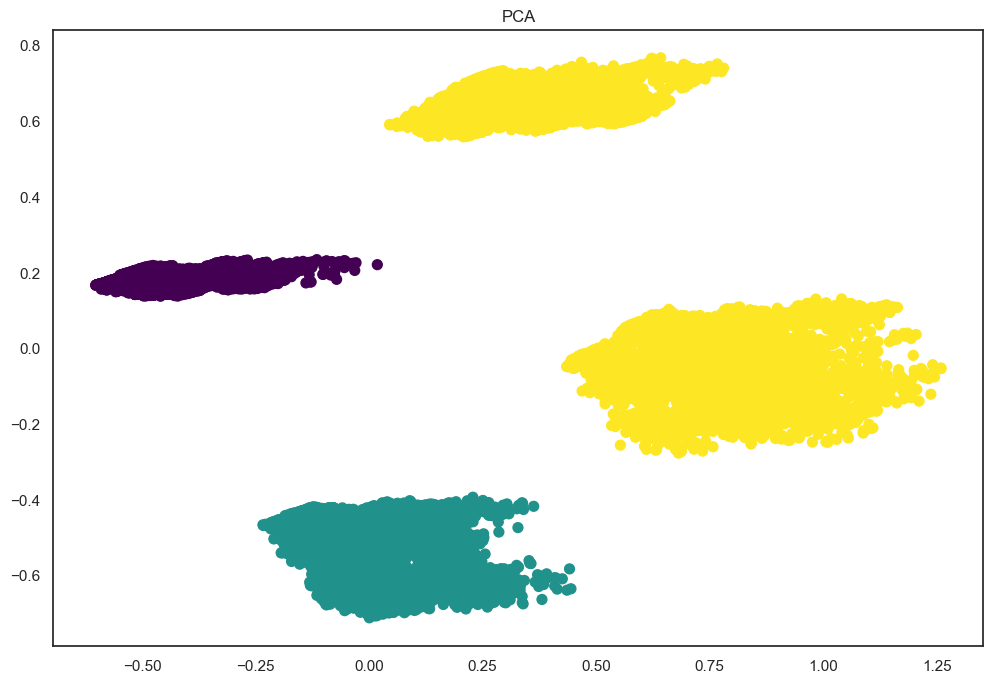

In [43]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

kmeans = KMeans(n_clusters=3, random_state=1)

kmeans.fit(X)


# Visualizing using PCA
pca = PCA(n_components=8)
res = pca.fit_transform(X)
plt.figure(figsize=(12,8))
plt.scatter(res[:,0], res[:,1], c=kmeans.labels_, s=50, cmap='viridis')
plt.title('PCA')

In [44]:
from itertools import combinations_with_replacement

labels = pd.DataFrame(kmeans.labels_)
labels = labels.rename(columns = {0: 'Assessment_Results'})
combinations = [[1, 4, 5], [1, 5, 4], [4, 1, 5], [4, 5, 1], [5, 1, 4], [5, 4, 1]]
for i in combinations:
    num_replace = {'Assessment_Results': {0: i[0], 1: i[1], 2: i[2]}}
    print((labels.replace(num_replace) - y).value_counts())

Assessment_Results
 0.0                  17667
-4.0                   8882
-3.0                   7466
 4.0                   7028
 3.0                   6457
 1.0                   6448
-1.0                   6424
dtype: int64
Assessment_Results
 0.0                  19511
-4.0                   8882
-3.0                   7466
 3.0                   7028
 4.0                   6457
 1.0                   6210
-1.0                   4818
dtype: int64
Assessment_Results
 0.0                  18741
-1.0                   8882
 4.0                   7028
 3.0                   6639
 1.0                   6448
-4.0                   6424
-3.0                   6210
dtype: int64
Assessment_Results
 0.0                  20918
-1.0                   8882
 3.0                   6639
 4.0                   6457
-3.0                   6448
 1.0                   6210
-4.0                   4818
dtype: int64
Assessment_Results
 0.0                  21787
 1.0                   7466
 3.0         

Text(0.5, 1.0, 'PCA')

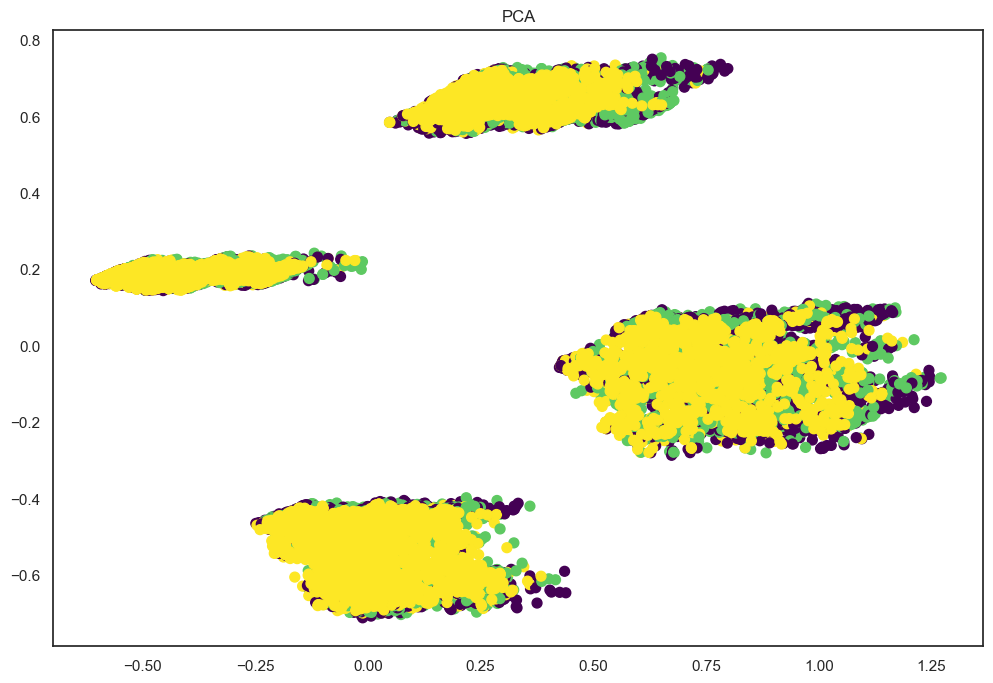

In [45]:
# Visualizing using PCA
pca = PCA(n_components=8)
res = pca.fit_transform(X)
plt.figure(figsize=(12,8))
plt.scatter(res[:,0], res[:,1], c=y.to_numpy(), s=50, cmap='viridis')
plt.title('PCA')

K-means разделяет формы (набор точек в нашей гиперплоскости, причем не произвольной формы), отсюда понимаем, что для наших данных, где выделить конкретные формы для целевого класса затруднительно K-means справляется плохо. Чтобы понять каких форм наши данные применим DBSCAN

## DBSCAN

In [46]:
from sklearn.cluster import DBSCAN

In [47]:
dbscan = DBSCAN(eps=0.0036, min_samples=4).fit(X)

Text(0.5, 1.0, 'PCA')

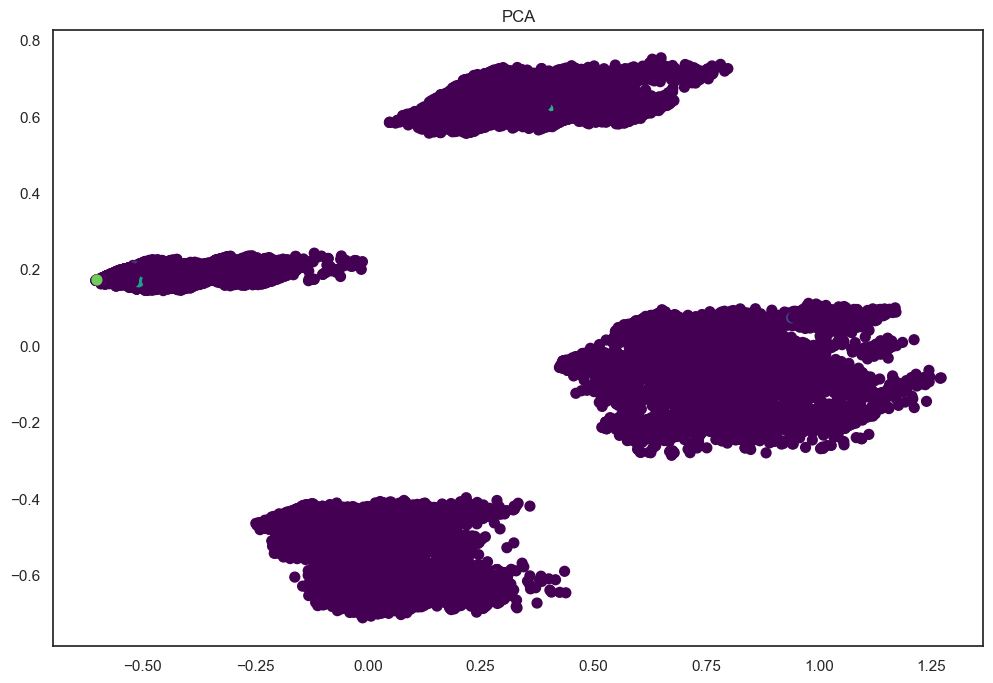

In [48]:
# Visualizing using PCA
pca = PCA(n_components=2)
res = pca.fit_transform(X)
plt.figure(figsize=(12,8))
plt.scatter(res[:,0], res[:,1], c=dbscan.labels_, s=50, cmap='viridis')
plt.title('PCA')

In [49]:
labels = pd.DataFrame(dbscan.labels_)
labels.value_counts()

-1     60217
 6        23
 16       12
 15       11
 1         9
 4         6
 7         6
 11        5
 23        5
 22        5
 13        5
 10        4
 19        4
 25        4
 24        4
 2         4
 3         4
 21        4
 20        4
 18        4
 9         4
 17        4
 5         4
 8         4
 14        4
 0         4
 12        4
 26        4
dtype: int64

Можем сделать вывод, что большинство точек находятся рядом с друг другом

In [52]:
labels = pd.DataFrame(dbscan.labels_)
labels = labels.rename(columns = {0: 'Assessment_Results'})
combinations = [[1, 4, 5], [1, 5, 4], [4, 1, 5], [4, 5, 1], [5, 1, 4], [5, 4, 1]]
for i in combinations:
    num_replace = {'Assessment_Results': {0: i[0], 1: i[1], 2: i[2]}}
    print((labels.replace(num_replace) - y).value_counts())

Assessment_Results
-2.0                  20108
-5.0                  20087
-6.0                  20025
 1.0                     27
 11.0                    22
 0.0                     14
 3.0                     12
 13.0                     9
 19.0                     5
 18.0                     5
 17.0                     5
 24.0                     4
 16.0                     4
 15.0                     4
 9.0                      4
 8.0                      4
 7.0                      4
 4.0                      4
-1.0                      4
 10.0                     3
 14.0                     3
 5.0                      3
 21.0                     3
-3.0                      3
 6.0                      2
 12.0                     1
 2.0                      1
 22.0                     1
 25.0                     1
dtype: int64
Assessment_Results
-2.0                  20108
-5.0                  20087
-6.0                  20025
 1.0                     32
 11.0                    

## Agglomerative clustering

In [53]:
from sklearn.cluster import AgglomerativeClustering

In [54]:
data_final = scaled_df
data_final['Assessment_Results'] = df.loc[:, df.columns == 'Assessment_Results']
data_final = data_final.sample(frac = 0.1)
X = data_final.loc[:, data_final.columns != 'Assessment_Results']
y = data_final.loc[:, df.columns == 'Assessment_Results']

In [58]:
agglomerative = AgglomerativeClustering(n_clusters = 3).fit(X)

Text(0.5, 1.0, 'PCA')

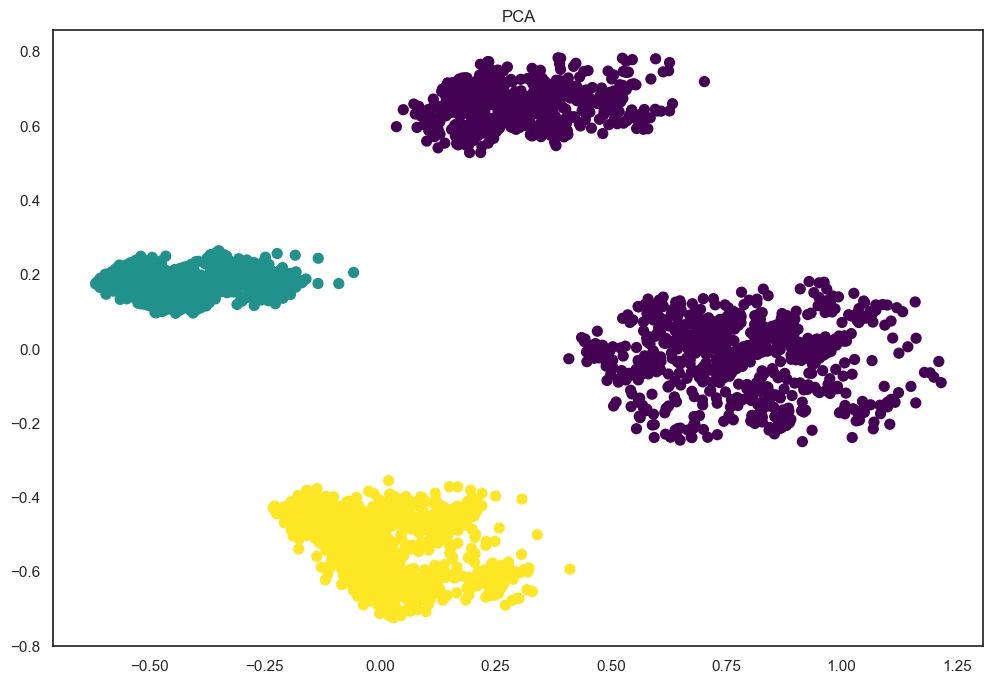

In [59]:
pca = PCA(n_components=2)
res = pca.fit_transform(X)
plt.figure(figsize=(12,8))
plt.scatter(res[:,0], res[:,1], c=agglomerative.labels_, s=50, cmap='viridis')
plt.title('PCA')

In [60]:
labels = pd.DataFrame(agglomerative.labels_)
labels = labels.rename(columns = {0: 'Assessment_Results'})
combinations = [[1, 4, 5], [1, 5, 4], [4, 1, 5], [4, 5, 1], [5, 1, 4], [5, 4, 1]]
for i in combinations:
    num_replace = {'Assessment_Results': {0: i[0], 1: i[1], 2: i[2]}}
    print((labels.replace(num_replace) - y).value_counts())

Assessment_Results
 0.0                  70
 3.0                  33
 4.0                  33
 1.0                  27
-3.0                  25
-4.0                  12
-1.0                  11
dtype: int64
Assessment_Results
 0.0                  64
 3.0                  33
 4.0                  33
 1.0                  28
-3.0                  25
-1.0                  16
-4.0                  12
dtype: int64
Assessment_Results
 0.0                  74
 4.0                  33
-3.0                  28
 1.0                  27
 3.0                  26
-1.0                  12
-4.0                  11
dtype: int64
Assessment_Results
 0.0                  69
 4.0                  33
 1.0                  28
-3.0                  27
 3.0                  26
-4.0                  16
-1.0                  12
dtype: int64
Assessment_Results
 0.0                  72
 3.0                  33
-3.0                  28
 4.0                  26
 1.0                  25
-1.0                  16
-4.

## Mean-shift

In [61]:
from sklearn.cluster import MeanShift

In [63]:
data_final = scaled_df
data_final['Assessment_Results'] = df.loc[:, df.columns == 'Assessment_Results']
data_final = data_final.sample(frac = 0.1)
X = data_final.loc[:, data_final.columns != 'Assessment_Results']
y = data_final.loc[:, df.columns == 'Assessment_Results']

In [64]:
shift = MeanShift(bandwidth=0.9).fit(X)

In [65]:
pd.DataFrame(shift.labels_).value_counts()

0    3338
1    1515
dtype: int64

Text(0.5, 1.0, 'PCA')

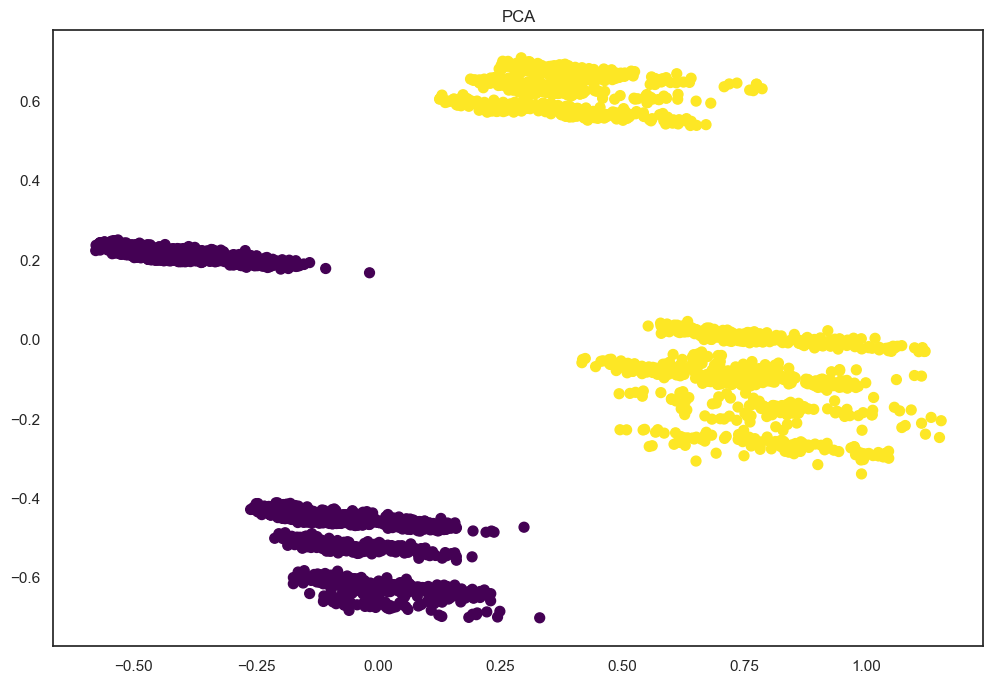

In [66]:
pca = PCA(n_components=2)
res = pca.fit_transform(X)
plt.figure(figsize=(12,8))
plt.scatter(res[:,0], res[:,1], c=shift.labels_, s=50, cmap='viridis')
plt.title('PCA')

In [67]:
labels = pd.DataFrame(shift.labels_)
labels = labels.rename(columns = {0: 'Assessment_Results'})
combinations = [[1, 4, 5], [1, 5, 4], [4, 1, 5], [4, 5, 1], [5, 1, 4], [5, 4, 1]]
for i in combinations:
    num_replace = {'Assessment_Results': {0: i[0], 1: i[1], 2: i[2]}}
    print((labels.replace(num_replace) - y).value_counts())

Assessment_Results
 0.0                  90
-3.0                  59
-4.0                  33
 3.0                  24
-1.0                  15
dtype: int64
Assessment_Results
 0.0                  79
-3.0                  59
-4.0                  33
 1.0                  26
 4.0                  24
dtype: int64
Assessment_Results
 0.0                  83
 3.0                  64
-1.0                  33
-3.0                  26
-4.0                  15
dtype: int64
Assessment_Results
 0.0                  74
 3.0                  64
-1.0                  33
 1.0                  26
 4.0                  24
dtype: int64
Assessment_Results
 4.0                  64
 1.0                  59
 0.0                  57
-3.0                  26
-4.0                  15
dtype: int64
Assessment_Results
 4.0                  64
 0.0                  59
 1.0                  59
 3.0                  24
-1.0                  15
dtype: int64


## EM

In [74]:
from sklearn.mixture import GaussianMixture

In [80]:
data_final = scaled_df
data_final['Assessment_Results'] = df.loc[:, df.columns == 'Assessment_Results']
X = data_final.loc[:, data_final.columns != 'Assessment_Results']
y = data_final.loc[:, df.columns == 'Assessment_Results']

In [85]:
y

,Assessment_Results
0,1.0
1,1.0
3,1.0
7,1.0
12,1.0
...,...
117483,5.0
117484,4.0
117486,4.0
117488,1.0


In [81]:
gm = GaussianMixture(n_components=3, random_state=0).fit(X)

In [82]:
pd.DataFrame(gm.predict(X)).value_counts()

1    17887
2    15366
0    15279
dtype: int64

Text(0.5, 1.0, 'PCA')

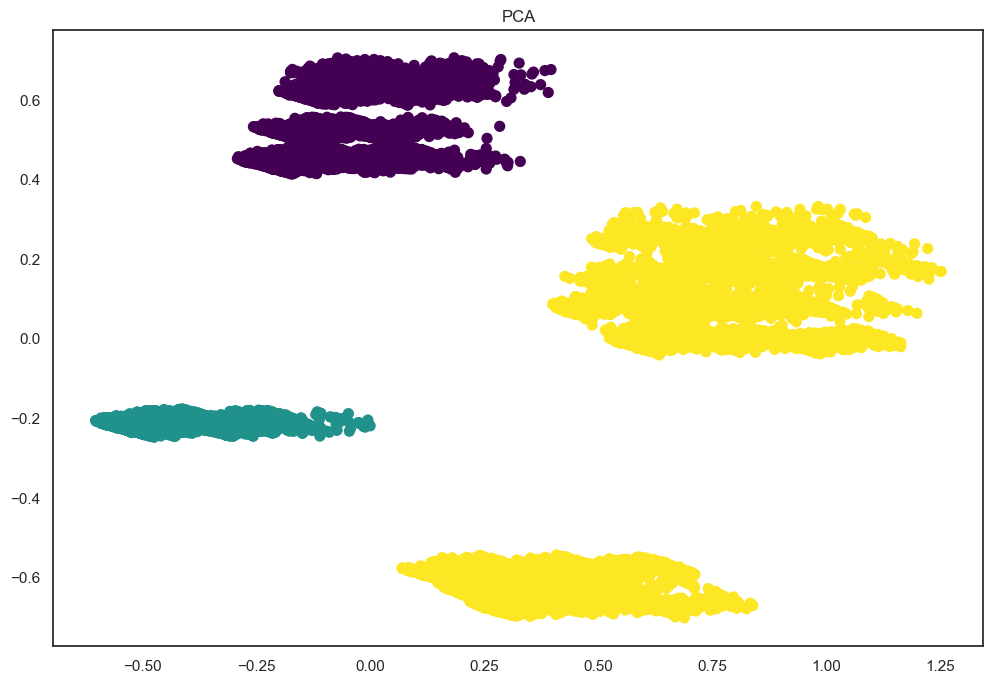

In [83]:
pca = PCA(n_components=2)
res = pca.fit_transform(X)
plt.figure(figsize=(12,8))
plt.scatter(res[:,0], res[:,1], c=gm.predict(X), s=50, cmap='viridis')
plt.title('PCA')

In [84]:
labels = pd.DataFrame(gm.predict(X))
labels = labels.rename(columns = {0: 'Assessment_Results'})
combinations = [[1, 4, 5], [1, 5, 4], [4, 1, 5], [4, 5, 1], [5, 1, 4], [5, 4, 1]]
for i in combinations:
    num_replace = {'Assessment_Results': {0: i[0], 1: i[1], 2: i[2]}}
    print((labels.replace(num_replace) - y).value_counts())

Assessment_Results
 0.0                  7023
 3.0                  3147
 4.0                  2835
 1.0                  2528
-3.0                  2498
-1.0                  1547
-4.0                  1350
dtype: int64
Assessment_Results
 0.0                  6829
 4.0                  3147
 1.0                  2957
 3.0                  2835
-3.0                  2498
-4.0                  1350
-1.0                  1312
dtype: int64
Assessment_Results
 0.0                  6957
-3.0                  2957
 4.0                  2835
 3.0                  2754
 1.0                  2528
-4.0                  1547
-1.0                  1350
dtype: int64
Assessment_Results
 0.0                  6880
 4.0                  3147
 1.0                  2957
 3.0                  2754
-3.0                  2528
-1.0                  1350
-4.0                  1312
dtype: int64
Assessment_Results
 0.0                  7025
-3.0                  2957
 3.0                  2835
 4.0            